# 第二问

In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName("A").config("b","c").getOrCreate()

In [2]:
ds=spark.read.csv(path='./data/german_credit.csv',header=True,inferSchema=True)
num_cols=['Account Balance','No of dependents']

In [3]:
#书P64
import numpy as np
import pandas as pd
import pyspark.sql.functions as F
def describe_pd(df_in,columns,deciles=False):
    '''输入一个ds，返回一个df'''
    if deciles:
        percentiles=np.array(range(0,110,10)) #密集分位点
    else:
        percentiles=[25,50,75]
    percs=np.transpose([np.percentile(df_in.select(x).collect(),percentiles) for x in columns])
    percs=pd.DataFrame(percs,columns=columns)   
    percs['summary']=[str(p)+'%' for p in percentiles]
    #以上计算得到了各分位点
    skew_kur=np.transpose([ds.select(F.skewness(x),F.kurtosis(x)).toPandas().values[0] for x in num_cols])
    skew_kur=pd.DataFrame(skew_kur,columns=columns)
    skew_kur['summary']=['skewness','kurtosis']
    
    spark_describe=df_in.describe() 
    spark_describe2=spark_describe.withColumn("Account Balance",spark_describe['Account Balance'].cast('float')).\
        withColumn("No of dependents",spark_describe['No of dependents'].cast('float')).toPandas()
    new_df=pd.concat([spark_describe2,percs,skew_kur],ignore_index=True)
    new_df=new_df.round(2) #所有结果保留两位小数
    return new_df[['summary']+columns]

#### 结果如下

In [4]:
describe_pd(ds,num_cols,deciles=True)

,summary,Account Balance,No of dependents
0,count,1000.00,1000.00
1,mean,2.58,1.15
2,stddev,1.26,0.36
3,min,1.00,1.00
4,max,4.00,2.00
5,0%,1.00,1.00
6,10%,1.00,1.00
7,20%,1.00,1.00
8,30%,2.00,1.00
9,40%,2.00,1.00


In [5]:
#检验
ds.select(F.skewness('Account Balance'),F.kurtosis('Account Balance')).show()
ds.select(F.skewness('No of dependents'),F.kurtosis('No of dependents')).show()
#偏度和峰度，以检验上面的结果

+-------------------------+-------------------------+
|skewness(Account Balance)|kurtosis(Account Balance)|
+-------------------------+-------------------------+
|     0.006946592744377805|      -1.6613901748002375|
+-------------------------+-------------------------+

+--------------------------+--------------------------+
|skewness(No of dependents)|kurtosis(No of dependents)|
+--------------------------+--------------------------+
|        1.9065793599765313|        1.6350448558885375|
+--------------------------+--------------------------+



# 第三问

In [6]:
import random #np的函数只能产生[0,1)上的均匀分布随机数
import numpy as np
from scipy.stats import norm
n=50
sample_data=list()
for _ in range(10000):
    #第a步
    Xs=np.array([random.uniform(0,1) for _ in range(n)])
    sig2=1/12
    mu=1/2
    #第b步
    R=1/(np.sqrt(n*sig2))*(np.sum(Xs)-n*mu)
    sample_data.append(R)
#第c步

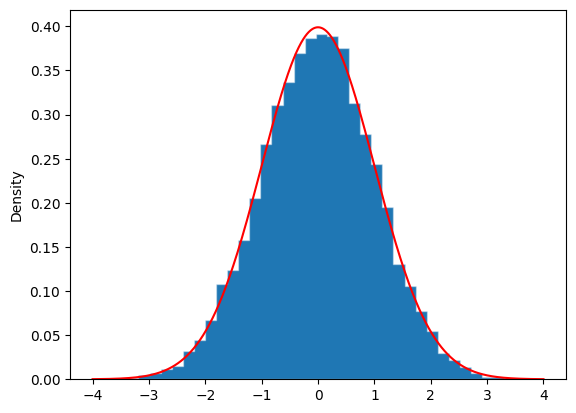

In [7]:
#第d步
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(sample_data,kde=False,
                stat="density",
                # norm_hist=True
                element="step",
                kde_kws=dict(cut=3),
                bins=40,
                alpha=1.,
                edgecolor=(1, 1, 1, .4))
plt.plot(np.linspace(-4,4,1000),norm.pdf(np.linspace(-4,4,1000)),'r')